# Movie Analysis for Microsoft

**Author:** Benjamin Dean
***

## Project Overview


This project explores six seperate datasets from IMDB.com, TheMovieDB.com, and the-numbers.com. Through analysis of this data 

### Business Problem

"Content is King"
Competitors Apple, Amazon and Netflix either create or secure original video content. In an effort to join them Microsoft has started their own movie studio. 

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_rows', 100)

#### Import datasets

In [2]:
ratings = pd.read_csv('data/zippedData/imdb.title.ratings.csv.gz')
basics = pd.read_csv('data/zippedData/imdb.title.basics.csv.gz')
directors = pd.read_csv('data/zippedData/imdb.title.crew.csv.gz')
names = pd.read_csv('data/zippedData/imdb.name.basics.csv.gz')
releases = pd.read_csv('data/zippedData/tmdb.movies.csv.gz')
budgets = pd.read_csv('data/zippedData/tn.movie_budgets.csv.gz')

## Data Preparation

#### Remove unwanted columns and rows

In [3]:
ratings = ratings.drop(ratings[ratings.numvotes < 100].index)
names = names[names['primary_profession'].str.contains('director', na=False)]
names.drop(columns = ['birth_year', 'death_year', 'known_for_titles'], inplace=True)
basics.drop(columns = ['original_title', 'runtime_minutes'], inplace=True)
directors.drop(columns = 'writers', inplace=True)
releases.drop(columns = ['genre_ids', 'id', 'original_language', 'popularity',\
                         'original_title', 'vote_average', 'vote_count'], inplace=True)

#### Rename columns to allow for dataset merging

In [4]:
directors.rename(columns={'directors': 'nconst'}, inplace=True)
releases.rename(columns={'title': 'primary_title'}, inplace=True)
budgets.rename(columns={'movie': 'primary_title'}, inplace=True)

In [5]:
releases.release_date = pd.to_datetime(releases.release_date)
budgets.release_date = pd.to_datetime(budgets.release_date)

In [6]:
genres_by_ratings = pd.merge(ratings, basics, on='tconst')\
                      .merge(directors, on='tconst')\
                      .merge(names, on='nconst')\
                      .merge(releases, on='primary_title' )\
                      .merge(budgets, on=['primary_title', 'release_date'])

#### Remove unwanted characters in order to make values convertable to intergers

In [7]:
series_list = ['production_budget', 'domestic_gross', 'worldwide_gross']
for series in series_list:
    for symbol in ['$', ',']:
        genres_by_ratings[series] = genres_by_ratings[series].str.replace(symbol,'')
    genres_by_ratings[series] = pd.to_numeric(genres_by_ratings[series])

In [8]:
genres_by_ratings['genre'] = genres_by_ratings['genres'].str.split(',')
genres_by_ratings['genre'] = genres_by_ratings['genre'].str[0]

#### Add profit column

In [9]:
genres_by_ratings['profit'] = genres_by_ratings['worldwide_gross'] - genres_by_ratings['production_budget']

In [10]:
avg_genre_rating = genres_by_ratings.groupby('genre').mean()
avg_genre_rating.sort_values(by='averagerating', ascending=False)
forplot = avg_genre_rating.drop(columns=['numvotes', 'start_year'])

In [11]:
budgets.rename(columns={'movie': 'primary_title'}, inplace=True)

In [12]:
genres_by_ratings = genres_by_ratings[genres_by_ratings.groupby('genres').genres.transform(len) >=3]
for_graph = genres_by_ratings.groupby('genres').mean()
for_graph = for_graph.loc[:,['production_budget', 'profit', 'worldwide_gross']]
for_graph.sort_values(by='profit', ascending=False, inplace=True)
for_graph = for_graph.head(25)
for_graph

,production_budget,profit,worldwide_gross
genres,,,
"Adventure,Drama,Sci-Fi",1.270000e+08,5.319741e+08,6.589741e+08
"Action,Adventure,Sci-Fi",1.663886e+08,5.234292e+08,6.898177e+08
"Adventure,Fantasy",2.316667e+08,4.695440e+08,7.012107e+08
"Adventure,Family,Fantasy",1.606818e+08,3.744137e+08,5.350955e+08
"Action,Adventure,Comedy",1.102500e+08,3.537390e+08,4.639890e+08
"Action,Adventure,Animation",1.119286e+08,3.250726e+08,4.370011e+08
"Adventure,Drama,Fantasy",5.300000e+07,2.844979e+08,3.374979e+08
"Action,Adventure,Fantasy",1.470200e+08,2.519460e+08,3.989660e+08
"Animation,Comedy,Family",6.800000e+07,2.417190e+08,3.097190e+08


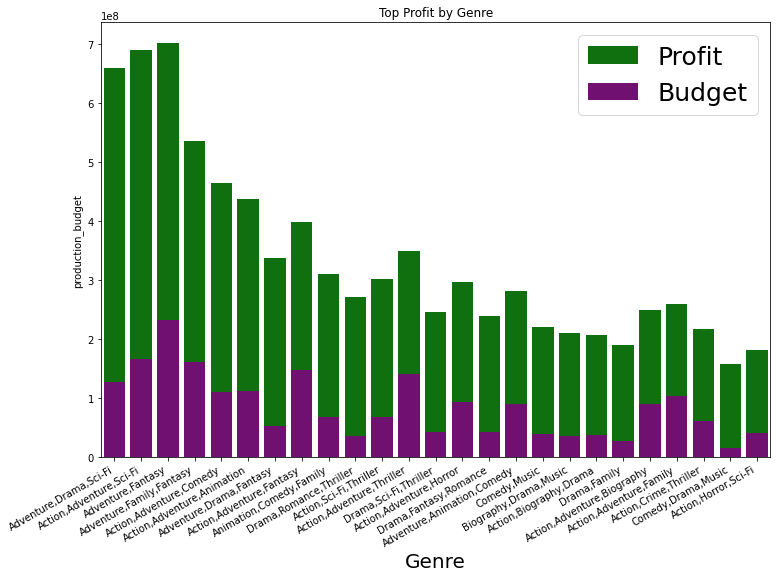

In [29]:
sns.set_context({'figure.figsize': (12,8)})
sns.barplot(x=for_graph.index, y=for_graph.worldwide_gross, color='green', label='Profit').set(title='Top Profit by Genre')
sns.barplot(x=for_graph.index, y=for_graph.production_budget, color='purple', label='Budget')
plt.xlabel('Genre', fontsize=20)
plt.xticks(rotation=30, ha='right')
plt.legend(prop={'size': 25});

In [15]:
second_graph = genres_by_ratings.groupby('primary_name').mean()
second_graph = second_graph.loc[:, ['averagerating', 'profit']]
second_graph.sort_values(by='profit', ascending=False, inplace=True)
second_graph = second_graph.head(25)

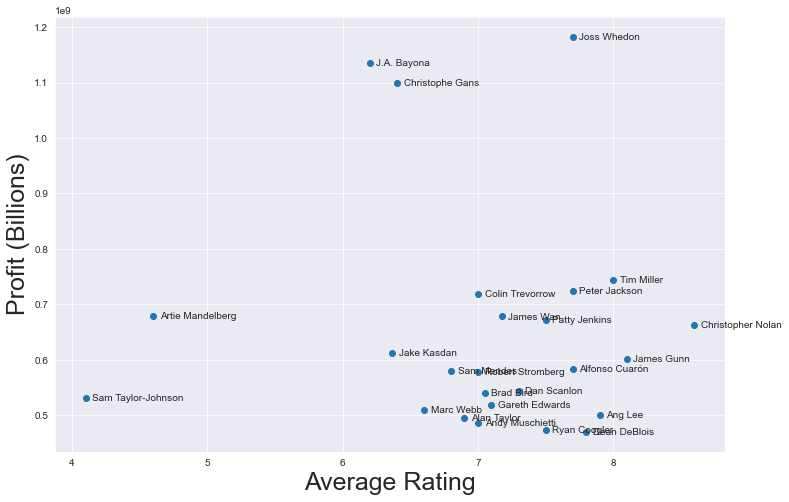

In [31]:
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
v = second_graph.averagerating
w = second_graph.profit
annotations = second_graph.index
plt.scatter(v,w)
plt.xlabel('Average Rating', fontsize=25)
plt.ylabel('Profit (Billions)', fontsize=25)
for i, label in enumerate(annotations):
    plt.annotate(label, (v.iloc[i]+.05, w.iloc[i]-5000000))
plt.show();

#### Ratings by Expenditure

In [21]:
genres_by_ratings.head()

,tconst,averagerating,numvotes,primary_title,start_year,genres,nconst,primary_name,primary_profession,release_date,id,production_budget,domestic_gross,worldwide_gross,genre,profit
0,tt1043726,4.2,50352,The Legend of Hercules,2014,"Action,Adventure,Fantasy",nm0001317,Renny Harlin,"producer,director,writer",2014-01-10,42,70000000,18848538,58953319,Action,-11046681
1,tt1171222,5.1,8296,Baggage Claim,2013,Comedy,nm0847859,David E. Talbert,"writer,director,producer",2013-09-27,38,8500000,21569509,22885836,Comedy,14385836
2,tt4649416,6.1,5212,Almost Christmas,2016,"Comedy,Drama",nm0847859,David E. Talbert,"writer,director,producer",2016-11-11,81,17000000,42065185,42493506,Comedy,25493506
3,tt2179136,7.3,401915,American Sniper,2014,"Action,Biography,Drama",nm0000142,Clint Eastwood,"actor,producer,director",2014-12-25,57,58000000,350126372,547326372,Action,489326372
4,tt2179136,7.3,401915,American Sniper,2014,"Action,Biography,Drama",nm0000142,Clint Eastwood,"actor,producer,director",2014-12-25,57,58000000,350126372,547326372,Action,489326372


In [23]:
third_graph = genres_by_ratings.loc[:, ['averagerating', 'production_budget', 'profit']]
third_graph['budget_grp'] = None
for element in range(len(third_graph.budget_grp)):
    if third_graph.production_budget.iloc[element] <= 25000000:
        third_graph.budget_grp.iloc[element] = '<=25'
    elif third_graph.production_budget.iloc[element] > 25000000 and third_graph.production_budget.iloc[element] <= 50000000:
        third_graph.budget_grp.iloc[element] = '<=50'
    elif third_graph.production_budget.iloc[element] > 50000000 and third_graph.production_budget.iloc[element] <= 75000000:
        third_graph.budget_grp.iloc[element] = '<=75'
    elif third_graph.production_budget.iloc[element] > 75000000 and third_graph.production_budget.iloc[element] <= 100000000:
        third_graph.budget_grp.iloc[element] = '<=100'
    elif third_graph.production_budget.iloc[element] > 100000000 and third_graph.production_budget.iloc[element] <= 125000000:
        third_graph.budget_grp.iloc[element] = '<=125'
    elif third_graph.production_budget.iloc[element] > 125000000 and third_graph.production_budget.iloc[element] <= 150000000:
        third_graph.budget_grp.iloc[element] = '<=150'
    elif third_graph.production_budget.iloc[element] > 150000000 and third_graph.production_budget.iloc[element] <= 175000000:
        third_graph.budget_grp.iloc[element] = '<=175'
    elif third_graph.production_budget.iloc[element] > 175000000 and third_graph.production_budget.iloc[element] <= 200000000:
        third_graph.budget_grp.iloc[element] = '<=200'
    else:
        third_graph.budget_grp.iloc[element] = '>200'

In [24]:
third_graph = third_graph.groupby('budget_grp').mean()

In [25]:
#plt.bar(t, u)
for symbol in ['<', '=', '>']:
    third_graph.index = third_graph.index.str.replace(symbol, '')
third_graph.index = pd.to_numeric(third_graph.index)
third_graph.sort_values(by='budget_grp')

,averagerating,production_budget,profit
budget_grp,,,
25,6.217969,1.083563e+07,2.418234e+07
50,6.403125,3.719727e+07,6.251479e+07
75,6.267021,6.181489e+07,1.054197e+08
100,6.132836,8.994030e+07,1.579318e+08
125,6.527778,1.150278e+08,2.508103e+08
150,6.539024,1.384878e+08,2.434726e+08
175,6.853846,1.654615e+08,4.635029e+08
200,7.103125,1.896562e+08,4.716546e+08
200,6.857143,2.603905e+08,6.378738e+08


<AxesSubplot:xlabel='budget_grp', ylabel='averagerating'>

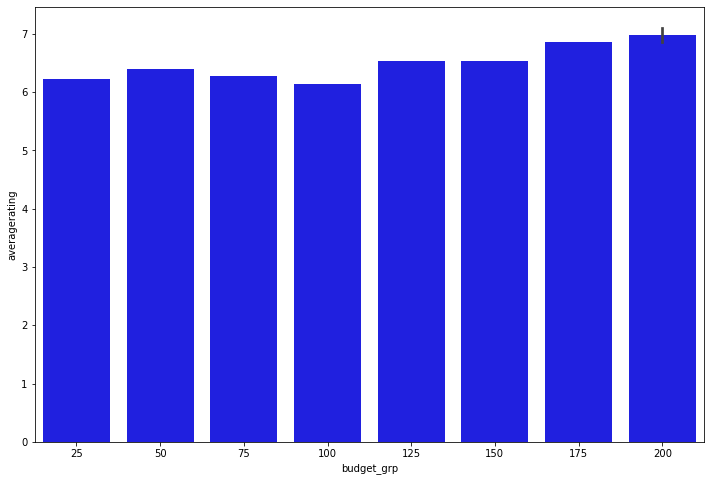

In [26]:
sns.set_context({'figure.figsize': (12,8)})
sns.barplot(x=third_graph.index, y=third_graph.averagerating, color='blue')